In [1]:
import warnings
warnings.filterwarnings('ignore')

In [147]:
import astropy.units as u
from  astropy.io import ascii
from spectral_cube import SpectralCube
from matplotlib import pyplot as plt
import numpy as np
from astropy.constants import c, h
import os
import scipy.optimize as spo
import scipy.integrate as integrate
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux
from numpy.polynomial.polynomial import Polynomial
import regions
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [3]:
# redshift
# Emissions des poussieres (PAH) pour les bumps du continium (15 microns)), problème de stitching : 
# calibration a courte
# longueur d'onde la plus stable chanel 1 puis on ajuste les autres artefacts. 

# Observations

## Setup

In [182]:
raies={1: 17.03484*u.um, 2: 12.2785*u.um, 3: 9.6649*u.um, 4: 8.0258*u.um, 5: 6.9091*u.um, 6: 6.1089*u.um, 7: 5.5115*u.um}

def getValues(obs: dict, obsNum: int):
    region_list = regions.Regions.read(f'observaciones/obs{obsNum}/subreg.reg')

    ch1 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch1-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch2 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch2-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch3 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch3-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch4 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch4-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)

    obs['channels']={1: ch1, 2: ch2, 3: ch3, 4: ch4}

    spectre_1 = ch1.mean(axis=(1, 2))
    spectre_2 = ch2.mean(axis=(1, 2))
    spectre_3 = ch3.mean(axis=(1, 2))
    spectre_4 = ch4.mean(axis=(1, 2))

    obs['spectres']={1: spectre_1, 2: spectre_2, 3: spectre_3, 4: spectre_4}

    S7_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[7])
    S6_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[6])
    S5_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[5])
    S4_redshift = ch2.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[4])
    S3_redshift = ch2.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[3])
    S2_redshift = ch3.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[2])
    S1_redshift = ch3.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[1])

    obs['raies']={1: S1_redshift, 2: S2_redshift, 3: S3_redshift, 4: S4_redshift, 5: S5_redshift, 6: S6_redshift, 7: S7_redshift}

    spectre_S1_redshift = S1_redshift.mean(axis=(1, 2))
    spectre_S2_redshift = S2_redshift.mean(axis=(1, 2))
    spectre_S3_redshift = S3_redshift.mean(axis=(1, 2))
    spectre_S4_redshift = S4_redshift.mean(axis=(1, 2))
    spectre_S5_redshift = S5_redshift.mean(axis=(1, 2))
    spectre_S6_redshift = S6_redshift.mean(axis=(1, 2))
    spectre_S7_redshift = S7_redshift.mean(axis=(1, 2))

    obs['spectre raies']={1: spectre_S1_redshift, 2: spectre_S2_redshift, 3: spectre_S3_redshift, 
                        4: spectre_S4_redshift, 5: spectre_S5_redshift, 6: spectre_S6_redshift, 7: spectre_S7_redshift}

    S7_freq = S7_redshift.with_spectral_unit(u.Hz)
    S6_freq = S6_redshift.with_spectral_unit(u.Hz)
    S5_freq = S5_redshift.with_spectral_unit(u.Hz)
    S4_freq = S4_redshift.with_spectral_unit(u.Hz)
    S3_freq = S3_redshift.with_spectral_unit(u.Hz)
    S2_freq = S2_redshift.with_spectral_unit(u.Hz)
    S1_freq = S1_redshift.with_spectral_unit(u.Hz)

    obs['frequences']={1: S1_freq, 2: S2_freq, 3: S3_freq, 4: S4_freq, 5: S5_freq, 6: S6_freq, 7: S7_freq}

    spectre_S7_freq = S7_freq.mean(axis=(1, 2))
    spectre_S6_freq = S6_freq.mean(axis=(1, 2))
    spectre_S5_freq = S5_freq.mean(axis=(1, 2))
    spectre_S4_freq = S4_freq.mean(axis=(1, 2))
    spectre_S3_freq = S3_freq.mean(axis=(1, 2))
    spectre_S2_freq = S2_freq.mean(axis=(1, 2))
    spectre_S1_freq = S1_freq.mean(axis=(1, 2))

    obs['spectre frequences']={1: spectre_S1_freq, 2: spectre_S2_freq, 3: spectre_S3_freq, 
                        4: spectre_S4_freq, 5: spectre_S5_freq, 6: spectre_S6_freq, 7: spectre_S7_freq}

### Params

In [183]:
obs1=dict()
obs2=dict()
obs6=dict()
observations=[obs1, obs2, obs6]
obs_tags=[1,2,6]

for obs, i in zip(observations, obs_tags):
    getValues(obs, i)

In [184]:
def getChannel(raie):
    if raie in (1,2): return 3
    elif raie in (3,4): return 2
    elif raie in (5,6,7): return 1
    
crenS={1:[2220,2460], 2:[275,525], 3:[1700,1940], 4:[410,650], 5:[2575,2815], 6:[1265,1505], 7:[780,1020]}

xmin=4000
xmax=8500
ymin=-10
ymax=130
imax=len(raies)
jmax=len(observations)

## Exploration

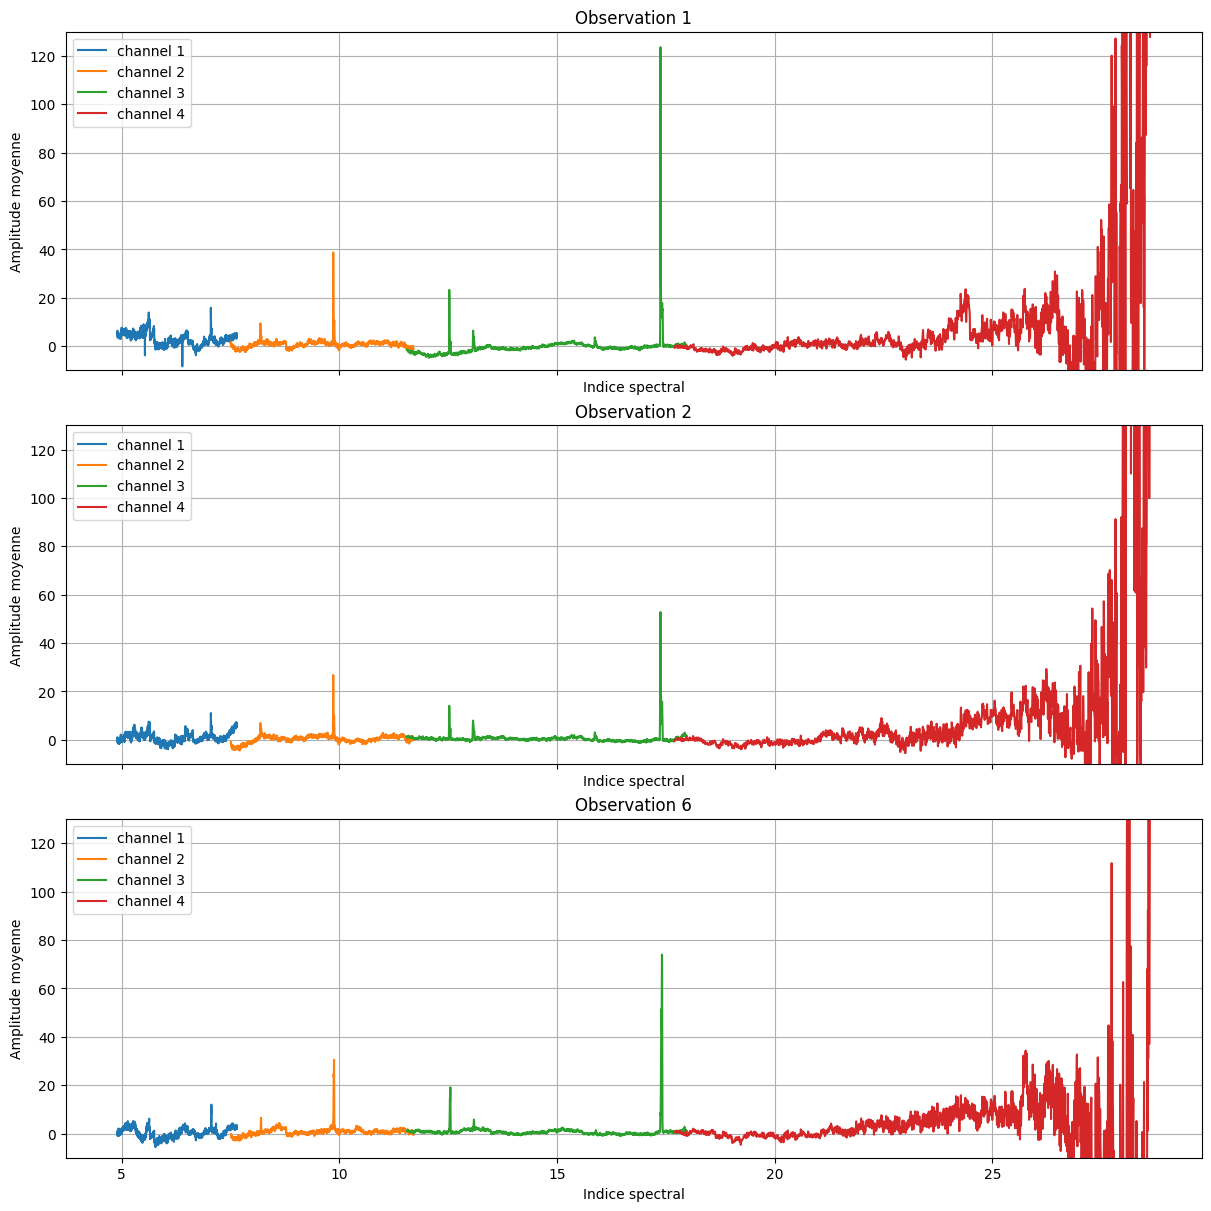

In [ ]:
fig, axs = plt.subplots(jmax,1,figsize=(12,4*jmax),sharex=True,sharey=True,layout='constrained')

for j, obs in enumerate(observations):
    ax = axs[j]
    for ch in range(1,5):
        ax.plot(obs['channels'][ch].spectral_axis,obs['spectres'][ch],label=f'channel {ch}')
    ax.set_xlabel('Indice spectral')  # Modifier si ce sont des longueurs d'onde ou fréquences
    ax.set_ylabel('Amplitude moyenne')
    ax.legend()
    ax.grid()
    ax.set_ylim(ymin, ymax)
    ax.set_title(f'Observation {obs_tags[j]}')

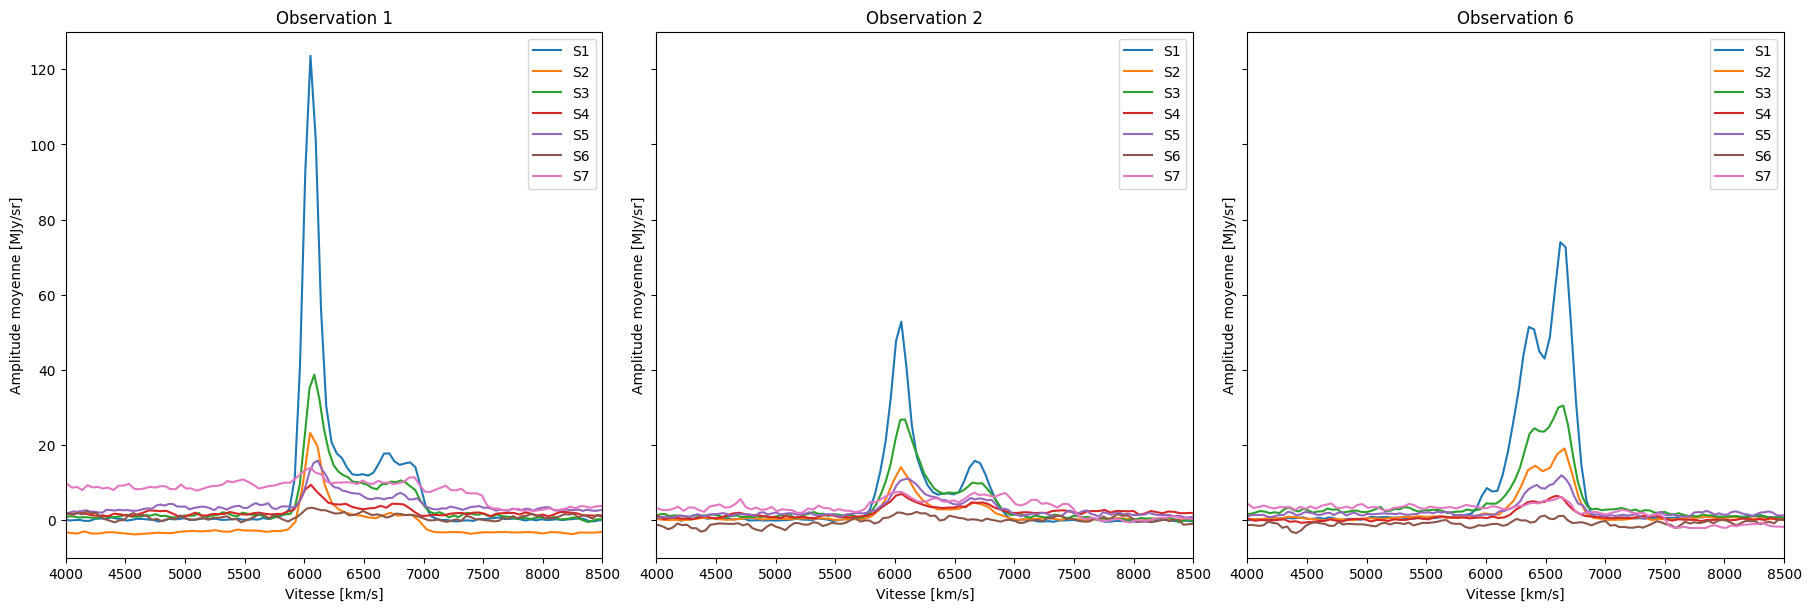

In [ ]:
# Comparaison des raies pour les 2 régions
fig, axs = plt.subplots(1,jmax,figsize=(6*jmax,6),sharex=True,sharey=True, layout='constrained')

for j, obs in enumerate(observations):
    ax = axs[j]
    for r in raies:
        ax.plot(obs['raies'][r].spectral_axis,obs['spectre raies'][r],label=f'S{r}')
    ax.set_title(f'Observation {obs_tags[j]}')
    ax.set_xlabel('Vitesse [km/s]')  
    ax.set_ylabel('Amplitude moyenne [MJy/sr]')
    ax.legend()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)


fig.savefig('identRaies.png', dpi=300, bbox_inches='tight')

## Flux

In [185]:
raies.pop(6)
imax=len(raies)

In [186]:
for obs in observations:
    obs['spectral_axis']=dict()
    obs['flux']=dict()
    obs['gaussian']=dict()
    for r in raies:
        spectral_axis = obs['spectre frequences'][r].spectral_axis[crenS[r][0]:crenS[r][1]]  # Axe spectral
        flux = obs['spectre frequences'][r].value[crenS[r][0]:crenS[r][1]] * u.MJy  # Flux 

        obs['spectral_axis'][r] = spectral_axis
        obs['flux'][r] = flux
        obs['gaussian'][r] = Spectrum1D(spectral_axis=spectral_axis, flux=flux)

In [187]:
# Calculer le flux dans une région spectrale définie
for j, obs in enumerate(observations):
    obs['region']=dict()
    obs['calculated_flux']=dict()
    obs['flux_in_wm2']=dict()
    for r in raies:   
        region = SpectralRegion(obs['gaussian'][r].spectral_axis.min(),obs['gaussian'][r].spectral_axis.max())
        calculated_flux = line_flux(obs['gaussian'][r], region)
        flux_in_wm2 = calculated_flux.to(u.W / (u.m**2))
        # print(f"Integrated flux Observation {obs_tags[j]} S{r}: {calculated_flux:.2e}" + str(' = ')  + f"{flux_in_wm2:.2e}")

        obs['region'][r] = region
        obs['calculated_flux'][r] = calculated_flux
        obs['flux_in_wm2'][r] = flux_in_wm2

In [188]:
# Conversion
for j, obs in enumerate(observations):
    obs['I_obs']=dict()
    for r in raies:
        omega_pix = obs['channels'][getChannel(r)].header[30]
        N_pix = np.count_nonzero(~np.isnan(obs['frequences'][r].max(axis=0).value))

        I_obs = obs['flux_in_wm2'][r].value*omega_pix*N_pix
        obs['I_obs'][r] = I_obs
        
        print(f'I Observation {obs_tags[j]} S{r}: = ' + str("%.2e"%(I_obs)) + ' W/m2')

I Observation 1 S1: = 7.11e-18 W/m2
I Observation 1 S2: = -1.19e-17 W/m2
I Observation 1 S3: = 7.82e-18 W/m2
I Observation 1 S4: = 9.05e-18 W/m2
I Observation 1 S5: = 1.41e-17 W/m2
I Observation 1 S7: = 4.70e-17 W/m2
I Observation 2 S1: = 3.72e-18 W/m2
I Observation 2 S2: = 3.02e-18 W/m2
I Observation 2 S3: = 6.66e-18 W/m2
I Observation 2 S4: = 7.19e-18 W/m2
I Observation 2 S5: = 8.54e-18 W/m2
I Observation 2 S7: = 1.69e-17 W/m2
I Observation 6 S1: = 7.74e-18 W/m2
I Observation 6 S2: = 5.06e-18 W/m2
I Observation 6 S3: = 1.02e-17 W/m2
I Observation 6 S4: = 3.10e-18 W/m2
I Observation 6 S5: = 7.85e-18 W/m2
I Observation 6 S7: = 4.83e-18 W/m2


### Flux sans Continium

In [189]:
# Enlever le continium
for obs in observations:
    obs['continium']=dict()
    obs['corrected_flux']=dict()
    for r in raies:
        spectral_axis = obs['spectral_axis'][r]

        mask = (spectral_axis < obs['gaussian'][r].spectral_axis[-100]) | (spectral_axis > obs['gaussian'][r].spectral_axis[100])
        p = Polynomial.fit(spectral_axis[mask].value, obs['gaussian'][r].flux[mask].value, deg=2)
        continium = p(spectral_axis.value)* u.MJy
        corrected_flux = obs['gaussian'][r].flux - continium 
        
        obs['continium'][r]=continium
        obs['corrected_flux'][r]=corrected_flux

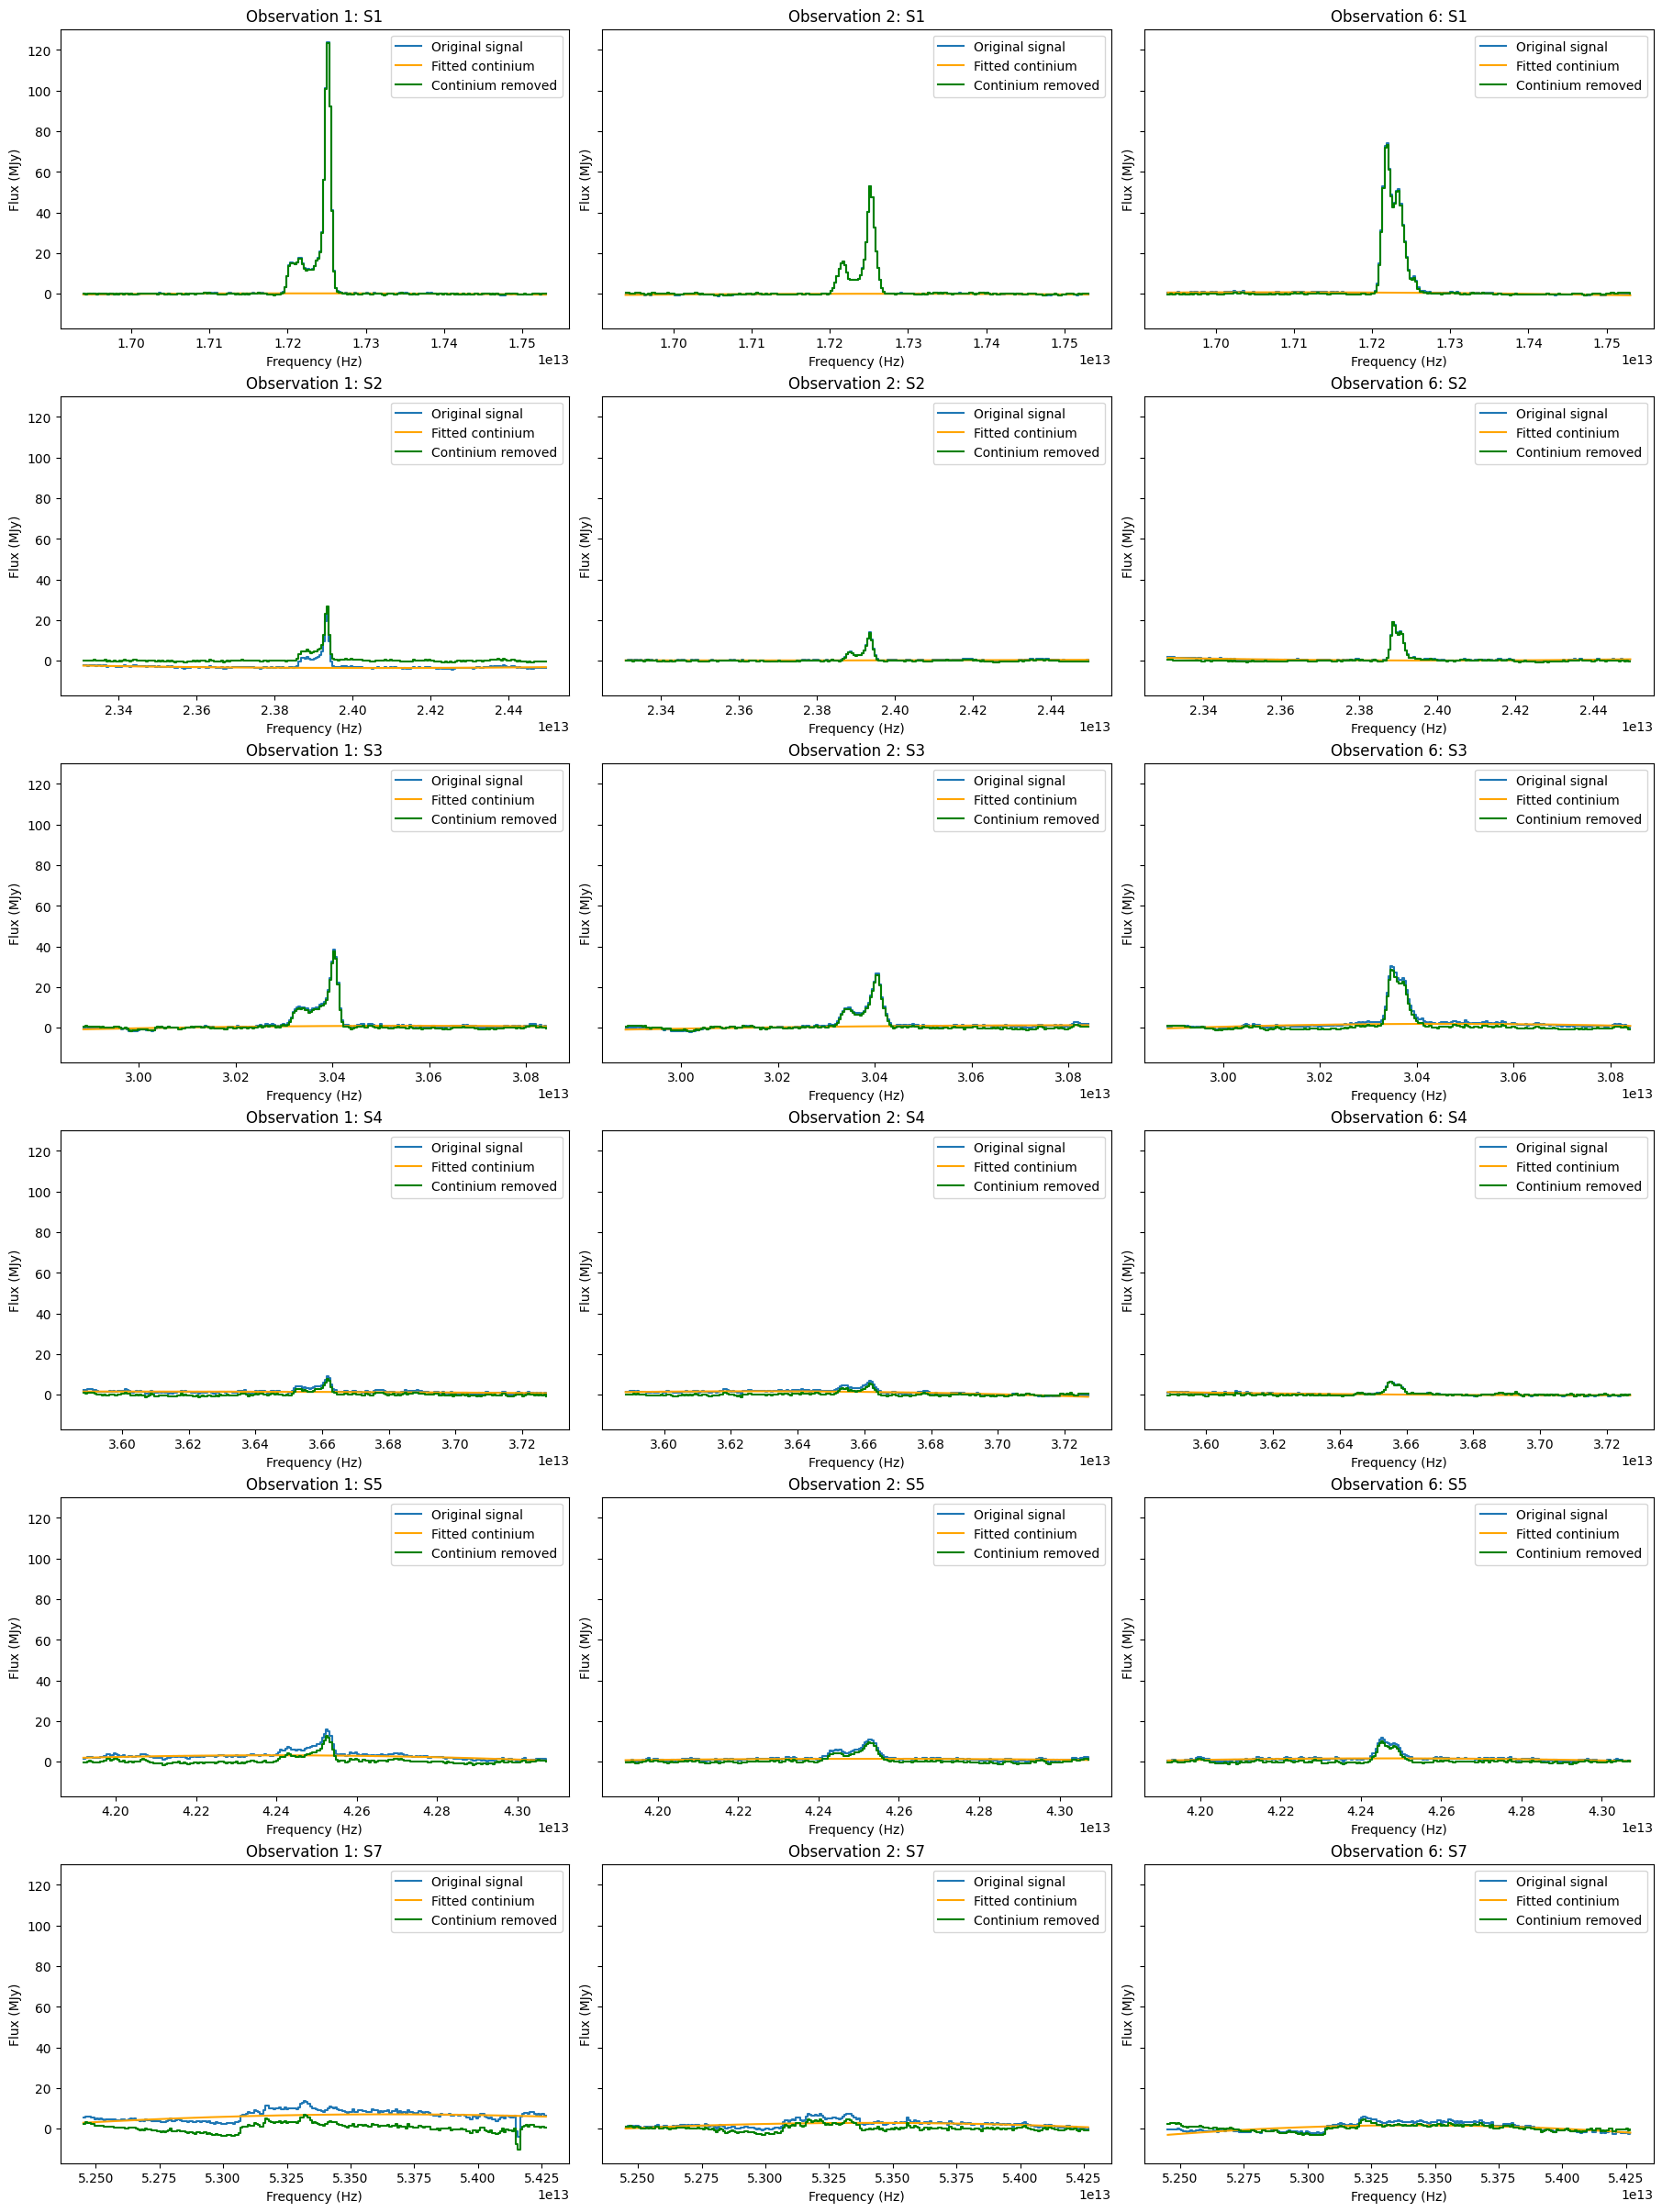

In [190]:
# Visualiser
fig, axs = plt.subplots(nrows=imax,ncols=jmax,figsize=(jmax*6,imax*4),
                        sharey=True, 
                        layout='constrained')

for j, obs in enumerate(observations):
    for r in raies:
        ax=axs[5 if r==7 else r-1][j]

        ax.step(obs['spectral_axis'][r], obs['gaussian'][r].flux, label='Original signal')
        ax.plot(obs['spectral_axis'][r], obs['continium'][r], label='Fitted continium', color='orange')
        ax.step(obs['spectral_axis'][r], obs['corrected_flux'][r], label='Continium removed', color='green')

        ax.set_title(f'Observation {obs_tags[j]}: S{r}')
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Flux (MJy)")
        ax.legend()

In [191]:
for obs in observations:
    obs['corrected_gaussian']=dict()
    for r in raies:
        obs['corrected_gaussian'][r] = Spectrum1D(spectral_axis=obs['spectral_axis'][r],
                                                  flux=obs['corrected_flux'][r])

In [192]:
# Calculer le flux dans une région spectrale définie
for obs in observations:
    obs['flux_in_wm2_corr']=dict()
    for r in raies:
        region = SpectralRegion(obs['gaussian'][r].spectral_axis[100],obs['gaussian'][r].spectral_axis[-100])
        calculated_flux = line_flux(obs['corrected_gaussian'][r], region)
        flux_in_wm2_corr = calculated_flux.to(u.W / (u.m**2))
        # print(f"Integrated flux Observation 1 S1: {calculated_flux:.2e}" + str(' = ')  + f"{flux_in_wm2_corr:.2e}")
        
        obs['flux_in_wm2_corr'][r]=flux_in_wm2_corr

In [193]:
# Conversion
for j, obs in enumerate(observations):
    obs['I_obs_corr']=dict()
    for r in raies:
        omega_pix = obs['channels'][getChannel(r)].header[30]
        N_pix = np.count_nonzero(~np.isnan(obs['frequences'][r].max(axis=0).value))

        I_obs_corr = obs['flux_in_wm2_corr'][r]*omega_pix*N_pix
        obs['I_obs_corr'][r] = I_obs_corr
        
        print(f'I Observation {obs_tags[j]} S{r}: =', I_obs_corr)

I Observation 1 S1: = 6.959373313237743e-18 W / m2
I Observation 1 S2: = 2.870039047187203e-18 W / m2
I Observation 1 S3: = 5.66670758991428e-18 W / m2
I Observation 1 S4: = 1.566498603727813e-18 W / m2
I Observation 1 S5: = 2.7452779901918554e-18 W / m2
I Observation 1 S7: = 3.8927978332763385e-18 W / m2
I Observation 2 S1: = 3.941380418745923e-18 W / m2
I Observation 2 S2: = 1.6953399404694277e-18 W / m2
I Observation 2 S3: = 4.6242088667135744e-18 W / m2
I Observation 2 S4: = 1.4473308386794973e-18 W / m2
I Observation 2 S5: = 2.815127067718718e-18 W / m2
I Observation 2 S7: = 2.0745043828649263e-18 W / m2
I Observation 6 S1: = 6.8517971063718256e-18 W / m2
I Observation 6 S2: = 2.6743867505784693e-18 W / m2
I Observation 6 S3: = 4.9970404312448926e-18 W / m2
I Observation 6 S4: = 1.539907734473703e-18 W / m2
I Observation 6 S5: = 1.99578092811796e-18 W / m2
I Observation 6 S7: = 2.4583246226968882e-18 W / m2


## Diagramme d'Excitation

In [201]:
# y-axis: ln(Nup/gup), x-axis: Eup/kB
def g(J):
    return J*(2*J+1)

def N(A, lbda, I):
    return 4*np.pi*lbda / (c*h) * I/A

E_up = {1:1015.0*u.K, 2:1682.0*u.K, 3:2503.4*u.K, 4:3474.6*u.K, 5:4586.7*u.K, 6:5829.8*u.K, 7:7196.6*u.K, 0: 509.9*u.K}
A_ij = {1: 4.76e-10*u.Hz, 2:2.76e-9*u.Hz, 3:9.84e-9*u.Hz, 4:2.64e-8*u.Hz, 5:5.88e-8*u.Hz, 6:1.14e-7*u.Hz, 7:2.00e-7*u.Hz}
g_up = dict((r, g(r+2)) for r in raies)
xaxis=np.array([E_up[r].value for r in raies])

In [202]:
for obs, j in zip(observations, obs_tags):
    obs['N_up']=dict()
    obs['yaxis_ln']=dict()

    N_up = dict((r, N(A_ij[r], raies[r], obs['I_obs_corr'][r]).to(1/u.cm*1/u.cm)) for r in raies)
    yaxis_ln=[np.log(N_up[r].value/g_up[r]) for r in raies]

    obs['N_up']=N_up
    obs['yaxis_ln']=yaxis_ln

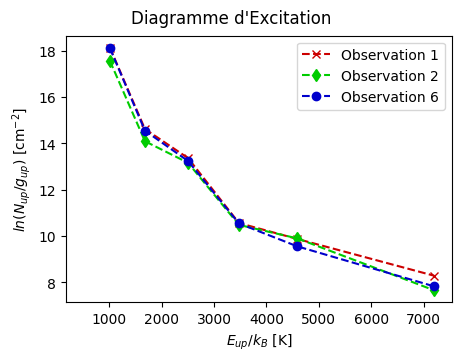

In [231]:
fig, ax = plt.subplots(figsize=(4.5,3.5), layout='constrained')
colores={1:'#cc0000',2:'#00cc00',6:'#0000cc'}
markers={1:'x',2:'d',6:'o'}

for obs, j in zip(observations, obs_tags):
    ax.plot(xaxis, obs['yaxis_ln'],
            label=f'Observation {j}', marker=markers[j], ls='--',
            c=colores[j])

fig.suptitle(f"Diagramme d'Excitation")
ax.set_xlabel("$E_{up}/k_B$ [K]")
ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
ax.set_xbound((np.float64(175.56499999999994), np.float64(7530.935)))
ax.legend()

fig.savefig('diagExcit.png', dpi=300, bbox_inches='tight')

In [204]:
def linea(x,m,b):
    return m*x+b

it_lim=3
xchaud=np.array([E_up[r].value for r in (1,2,3)])
xfroid=np.array([E_up[r].value for r in (4,5,7)])

for obs, j in zip(observations, obs_tags):
    obs['popt_fr']=dict()
    obs['popt_ch']=dict()

    popt, pcov = spo.curve_fit(linea, xfroid, obs['yaxis_ln'][3:])
    obs['popt_fr']=popt
    
    popt, pcov = spo.curve_fit(linea, xchaud, obs['yaxis_ln'][:3])
    obs['popt_ch']=popt

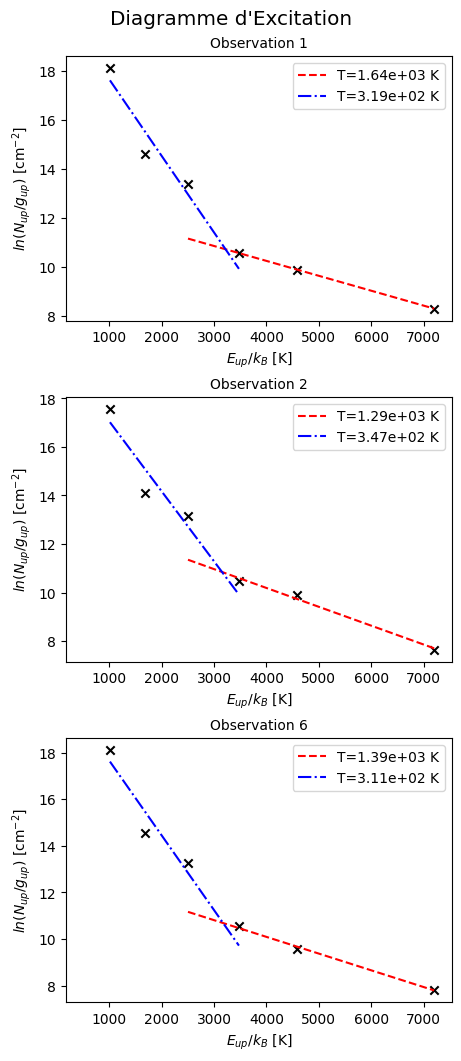

In [233]:
fig, axs = plt.subplots(nrows=3,figsize=(4.5,3.5*3), layout='constrained')

for obs, j, ax in zip(observations, obs_tags, axs):
    ax.scatter(xaxis, obs['yaxis_ln'], marker='x', c='#000000')

    ax.plot(np.concatenate((xchaud[-1:],xfroid)), linea(np.concatenate((xchaud[-1:],xfroid)),obs['popt_fr'][0],obs['popt_fr'][1]), 
            '--', label=f"T={-1/obs['popt_fr'][0]:.2e} K", c='#FF0000')
            
    ax.plot(np.concatenate((xchaud,xfroid[:1])), linea(np.concatenate((xchaud,xfroid[:1])),obs['popt_ch'][0],obs['popt_ch'][1]), 
            '-.', label=f"T={-1/obs['popt_ch'][0]:.2e} K", c='#0000FF')

    ax.set_title(f'Observation {j}', size="medium")
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
    ax.set_xbound((np.float64(175.56499999999994), np.float64(7530.935)))
    ax.legend()

fig.suptitle(f"Diagramme d'Excitation", size="x-large")
fig.savefig('diagExcitFit.png', dpi=300, bbox_inches='tight')

### Extra

In [50]:
def lineaCompleja(xarray, m_ch, m_fr, b_ch, b_fr, param=0.1):
    yarray=list()

    umbral_ch = (param-b_ch+b_fr)/(m_ch-m_fr)
    umbral_fr = (param-b_fr+b_ch)/(m_fr-m_ch)

    for x in xarray:
        if x <= umbral_ch: yarray.append(linea(x,m_ch,b_ch))
        elif x >= umbral_fr: yarray.append(linea(x,m_fr,b_fr))
        else: yarray.append(linea(x,(m_fr+m_ch)/2,(b_ch+b_fr)/2))
    return yarray

In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(6*3,6), layout='constrained')
colores={1:'#d62976',2:'#962fbf',6:'#fa7e1e'}

for obs, j, ax in zip(observations, obs_tags, axs):
    ax.scatter(xaxis, obs['yaxis_ln'], marker='x', c=colores[j])

    ax.plot(xaxis, lineaCompleja(xaxis,obs['popt_ch'][0],obs['popt_fr'][0],obs['popt_ch'][1],obs['popt_fr'][1]), 
            '--', c=colores[j])

    ax.set_title(f'Observation {j}')
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")

fig.suptitle(f"Diagramme d'Excitation")
fig.savefig('diagExcitFit.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(6*3,6), layout='constrained')
colores={1:'#d62976',2:'#962fbf',6:'#fa7e1e'}
xarray = np.linspace(E_up[0].value, E_up[7].value, num=100, endpoint=True)

for obs, j, ax in zip(observations, obs_tags, axs):
    ax.scatter(xaxis, obs['yaxis_ln'], marker='x', c=colores[j])
    
    ax.scatter([E_up[0].value],
               lineaCompleja([E_up[0].value], obs['popt_ch'][0],obs['popt_fr'][0],obs['popt_ch'][1],obs['popt_fr'][1]),
               marker='D', c=colores[j])

    ax.plot(xarray,
            lineaCompleja(xarray, obs['popt_ch'][0],obs['popt_fr'][0],obs['popt_ch'][1],obs['popt_fr'][1]), 
            '--', c=colores[j])

    ax.set_title(f'Observation {j}')
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")

fig.suptitle(f"Diagramme d'Excitation")
fig.savefig('diagExcitFit.png', dpi=300, bbox_inches='tight')

# Models

## Lecture

In [3]:
files=["energetics.out","excit.out","H2_lev_cd.out","H2_line_loc.out","H2_line_int.out","H2_lev_ln.out","intensity.out","mhd_phys.out"]

Cmodels=dict()
# for model in [f for f in os.listdir("shock_grid") if 'C'==f[0]]:
for model in ['Cn4b1v10', 'Cn4b1v30', 'Cn4b5v10', 'Cn4b5v30']:
    Cmodels[model] = dict()
    for param in [f for f in os.listdir(f"shock_grid/{model}") if f in files]:
        # print(model, param)
        try:
            Cmodels[model][param.split('.')[0]]=ascii.read(f"shock_grid/{model}/{param}",guess=False)
        except ValueError as err:
            Cmodels[model][param.split('.')[0]]=ascii.read(f"shock_grid/{model}/{param}",data_end=int(str(err).split("line")[-1]))

Jmodels=dict()
# for model in [f for f in os.listdir("shock_gr, alpha=0.5)id") if 'J'==f[0]]:
for model in ['Jn4v10', 'Jn4v30', 'Jn6v10', 'Jn6v30']:
    Jmodels[model] = dict()
    for param in [f for f in os.listdir(f"shock_grid/{model}") if f in files]:
        # print(model, param)
        try:
            Jmodels[model][param.split('.')[0]]=ascii.read(f"shock_grid/{model}/{param}",guess=False)
        except ValueError as err:
            Jmodels[model][param.split('.')[0]]=ascii.read(f"shock_grid/{model}/{param}",data_end=int(str(err).split("line")[-1]))

In [17]:
def name_to_desc(model):
    tipo=model[0]
    nH=model[2]
    v=model[-2:]
    
    str_nh="$n_{H_i}$"
    str_cm="cm^{-3}"
    str_km="km/s"

    return f"Choc {tipo}, {str_nh}={nH} ${str_cm}$, $v$={v} ${str_km}$"

## Parametres physiques

In [5]:
phys=["nH","Tn","Vsound","Vmagnet","DensityN","DensityI"]
colores=["#ab369d","#d94165","#ffbc1f","#037758","#118ab2","#073b4c"]

In [ ]:
fig, axs = plt.subplots(ncols=3,nrows=4,figsize=(15,15), layout='constrained')
for i, model in enumerate(Cmodels):
    data = Cmodels[model]['mhd_phys']
    axlin=axs[i]

    for j, ax in enumerate(axlin):
        ax.plot(data["distance"], data[phys[2*j]], label=phys[2*j], c=colores[2*j])
        ax.plot(data["distance"], data[phys[2*j+1]], label=phys[2*j+1], c=colores[2*j+1])

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("distance")
        ax.legend(loc='upper left', ncols=2)
        
        if j==0: ax.set_ylabel(model)
fig.suptitle(f"C Shocks")
fig.savefig('Cmodels_phys.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(ncols=3,nrows=4,figsize=(15,15), layout='constrained')
for i, model in enumerate(Jmodels):
    data = Jmodels[model]['mhd_phys']
    axlin=axs[i]

    for j, ax in enumerate(axlin):
        ax.plot(data["distance"], data[phys[2*j]], label=phys[2*j], c=colores[2*j])
        ax.plot(data["distance"], data[phys[2*j+1]], label=phys[2*j+1], c=colores[2*j+1])

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("distance")
        ax.legend(loc='upper left', ncols=2)
        
        if j==0: ax.set_ylabel(model)
fig.suptitle(f"J Shocks")
fig.savefig('Jmodels_phys.png', dpi=300, bbox_inches='tight')

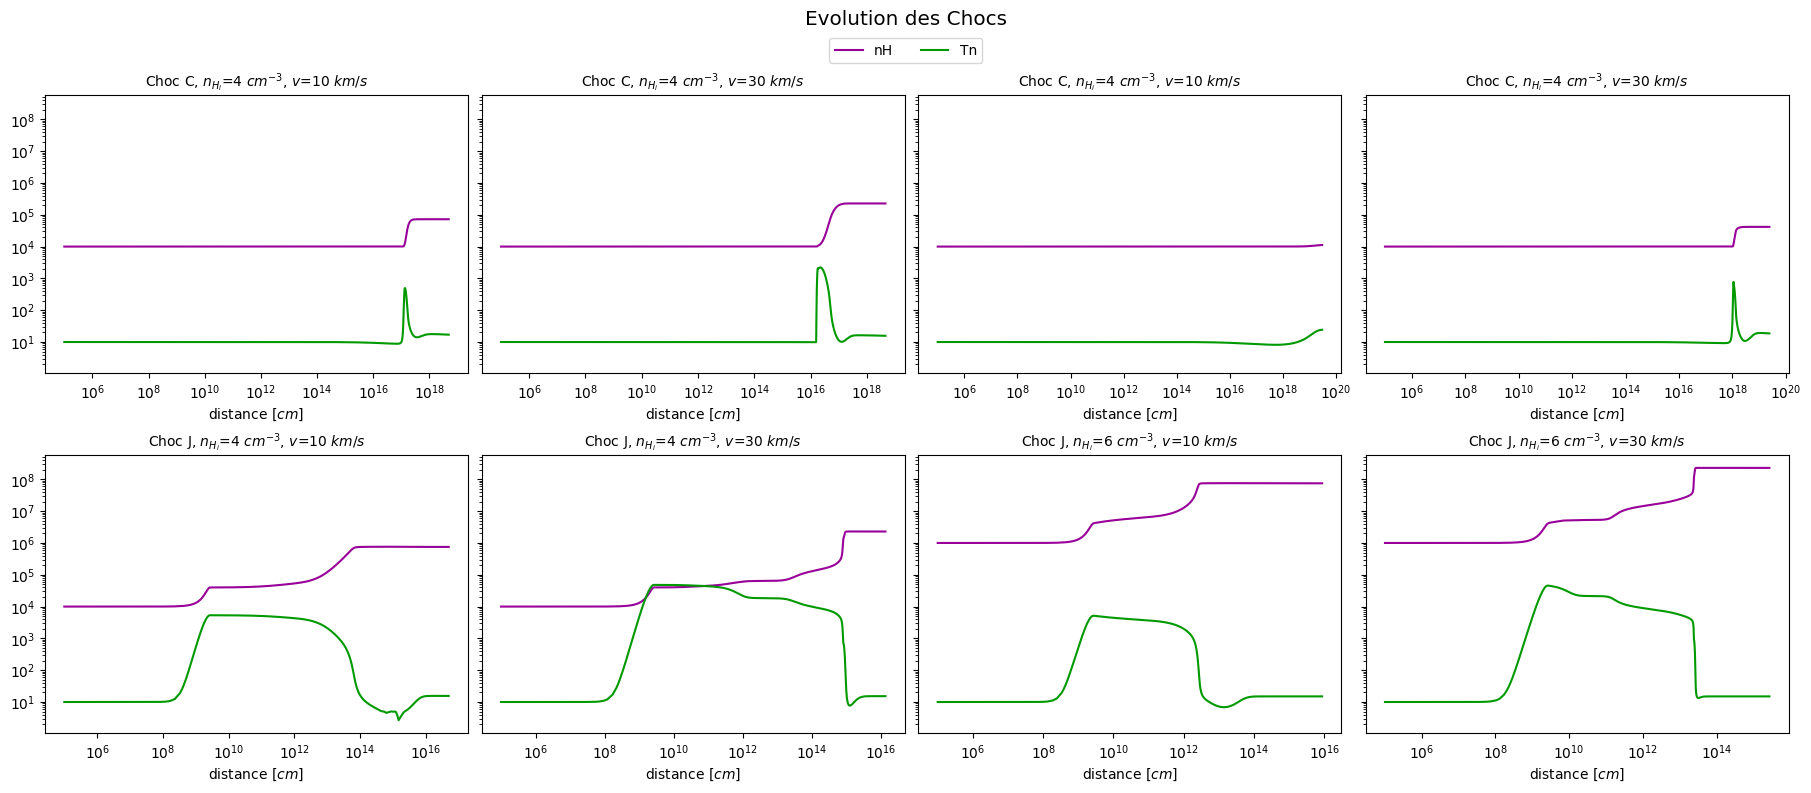

In [212]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(18,7.2), layout='constrained', sharey=True)
colores=('#990099', '#009900')

for axsL, models in zip(axs, (Cmodels, Jmodels)):
    for ax, model in zip(axsL, models):
        data = models[model]['mhd_phys']

        for prop, color in zip(("nH","Tn"), colores):
            ax.plot(data["distance"], data[prop], label=prop if model == 'Cn4b5v10' else None, c=color)

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("distance [$cm$]")
        ax.set_title(name_to_desc(model), size='medium')

fig.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.05))
fig.suptitle(f"Evolution des Chocs", size="x-large", y=1.08)
fig.savefig('models_phys.png', dpi=300, bbox_inches='tight')

## Parametre energetiques

In [25]:
energ=["Tn","Energy","Energy_kin","Energy_the","Energy_int","Energy_mag","Energy_vis"]
colores=["#54319b","#ab369d","#d94165","#ec7f42","#ffbc1f","#037758","#118ab2","#073b4c"]

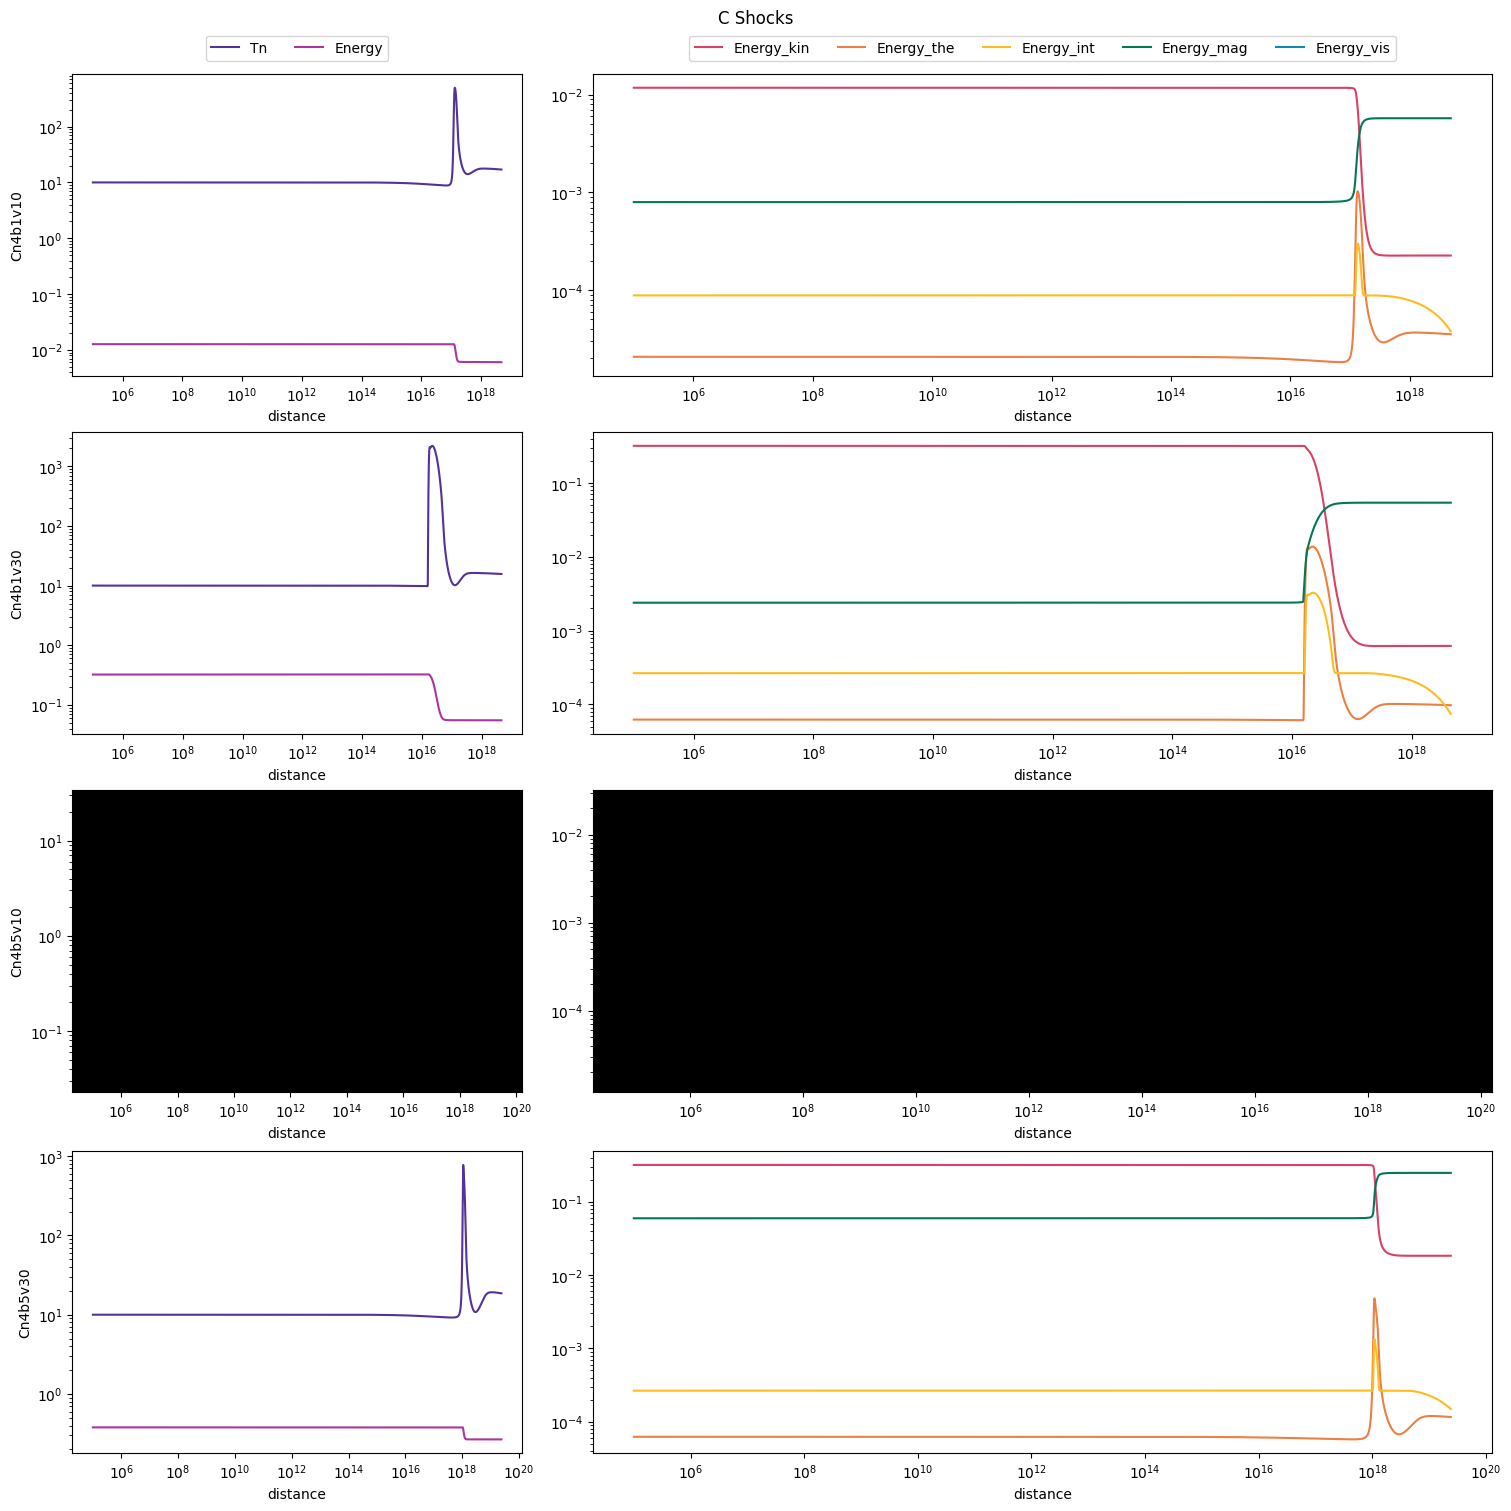

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(15,15), layout='constrained', width_ratios=(1,2))
for i, model in enumerate(Cmodels):
    data = Cmodels[model]['energetics']
    axlin=axs[i]

    for j,jmax,ax in zip(range(2),(2,5),axlin):
        for k in range(jmax):
            ax.plot(data["distance"], data[energ[k+2*j]], label=energ[k+2*j], c=colores[k+2*j])

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("distance")
        if i==0: ax.legend(loc='upper center',ncols=jmax, bbox_to_anchor=(0.5,1.15))
        if model == 'Cn4b5v10': ax.add_artist(mpatches.Rectangle((0,0), 1e30,1e30, ec="none", color='black', alpha=1, zorder=15))
        
        if j==0: ax.set_ylabel(model)
fig.suptitle(f"C Shocks")
fig.savefig('Cmodels_energ.png', dpi=300, bbox_inches='tight')

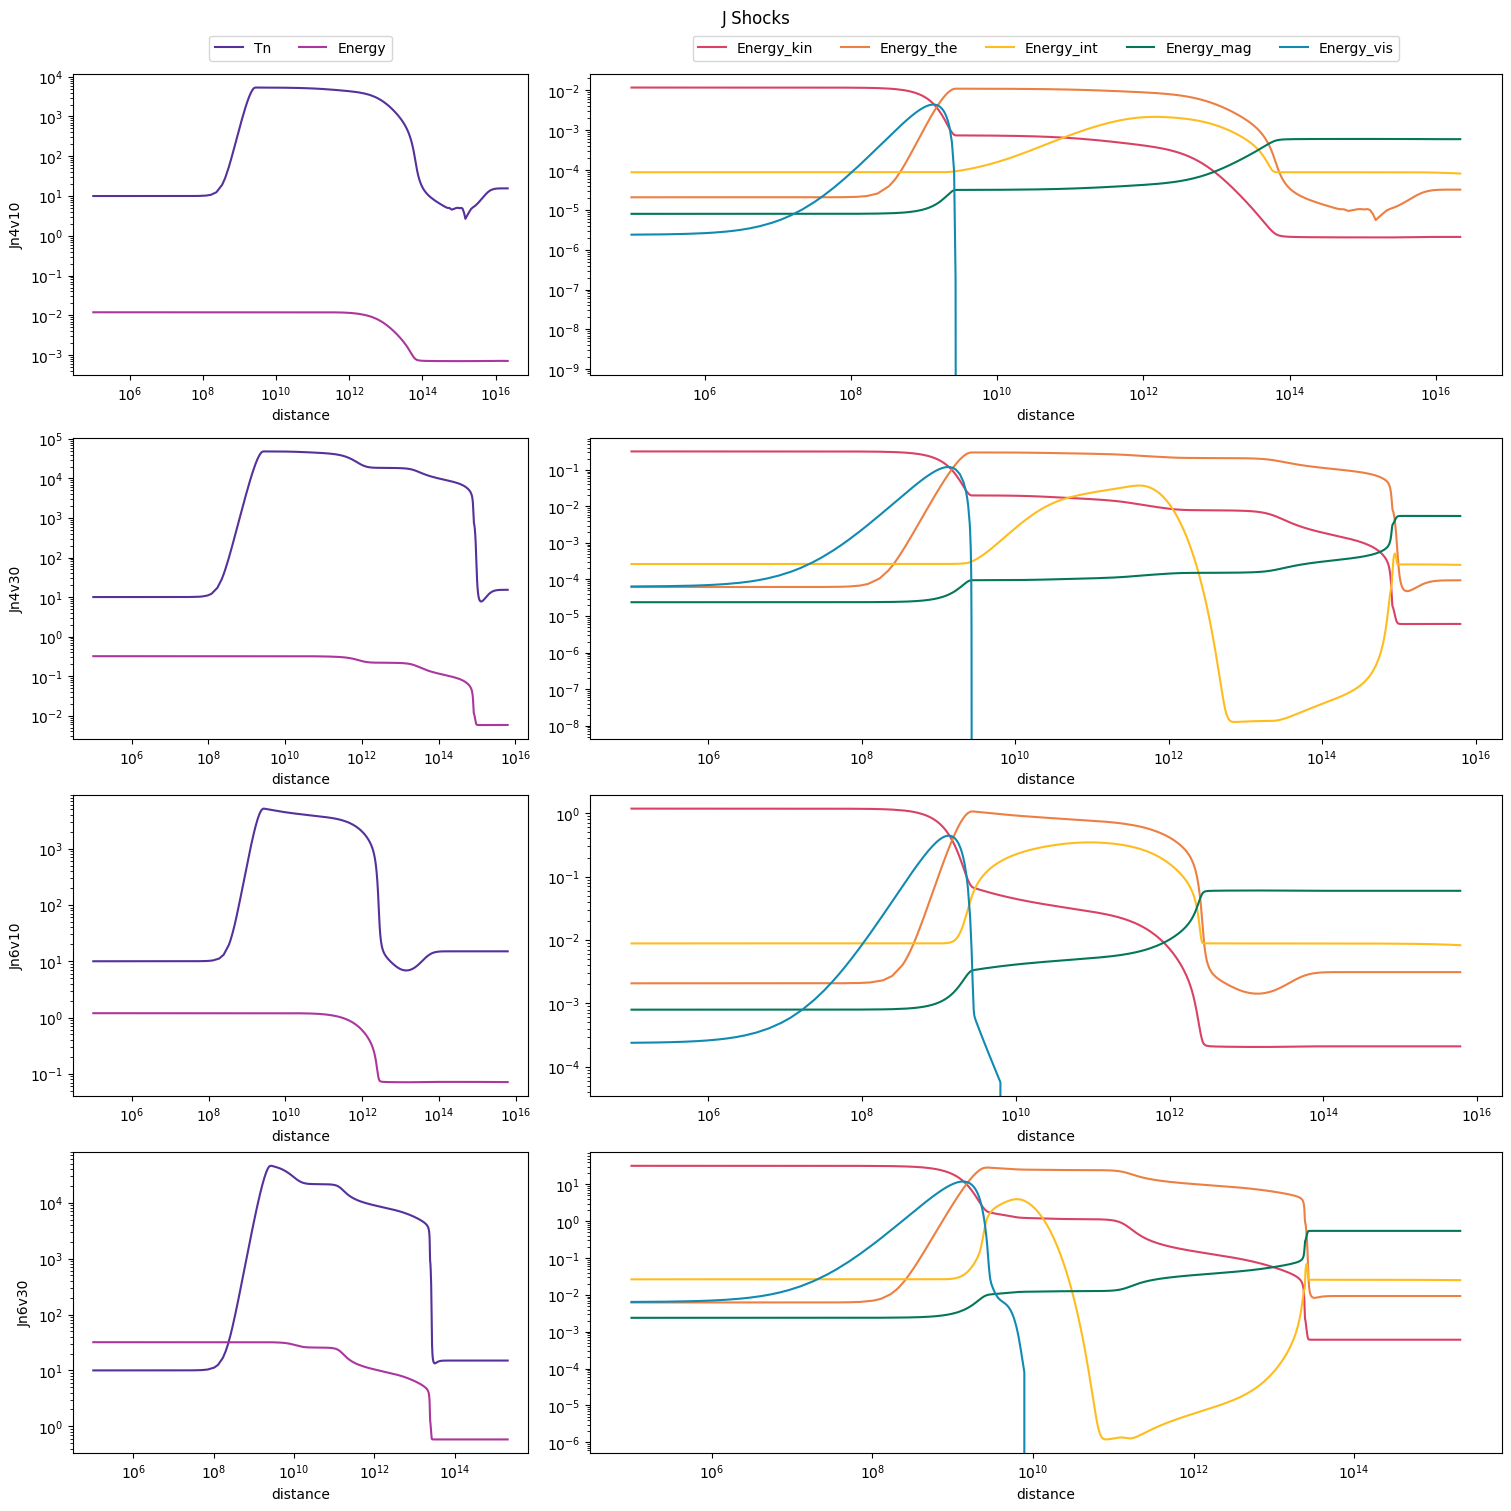

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(15,15), layout='constrained', width_ratios=(1,2))
for i, model in enumerate(Jmodels):
    data = Jmodels[model]['energetics']
    axlin=axs[i]

    for j,jmax,ax in zip(range(2),(2,5),axlin):
        for k in range(jmax):
            ax.plot(data["distance"], data[energ[k+2*j]], label=energ[k+2*j], c=colores[k+2*j])

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("distance")
        if i==0: ax.legend(loc='upper center',ncols=jmax, bbox_to_anchor=(0.5,1.15))
        
        if j==0: ax.set_ylabel(model)
fig.suptitle(f"J Shocks")
fig.savefig('Jmodels_energ.png', dpi=300, bbox_inches='tight')

## Emmissivité

In [23]:
emm=["Tn","0-0S(0)","0-0S(1)","0-0S(2)","0-0S(3)","0-0S(4)","0-0S(5)","0-0S(6)","0-0S(7)"]

for models in (Cmodels, Jmodels):
    for i, model in enumerate(models):
        data = models[model]['H2_line_loc']

        mask=models[model]['energetics']["Energy_kin"]-models[model]['energetics']["Energy_kin"].min() < (models[model]['energetics']["Energy_kin"].max()-models[model]['energetics']["Energy_kin"].min())*(1-.9999)
        ceil=models[model]['energetics'][mask]['distance'].min()
        models[model]['ceil']=ceil

### Plots

In [ ]:
fig, axs = plt.subplots(ncols=1,nrows=4,figsize=(10,15), layout='constrained')
for i, model in enumerate(Cmodels):
    data = Cmodels[model]['H2_line_loc']

    mask=Cmodels[model]['energetics']["Energy_kin"]-Cmodels[model]['energetics']["Energy_kin"].min() < (Cmodels[model]['energetics']["Energy_kin"].max()-Cmodels[model]['energetics']["Energy_kin"].min())*(1-.9999)
    ceil=Cmodels[model]['energetics'][mask]['distance'].min()
    ceil=Cmodels[model]['ceil']
    Dmask=Cmodels[model]['energetics']["Tn"]>17
    
    axi=axs[i]
    axi.plot(data[Dmask]["distance"], data[Dmask][emm[0]], label=emm[0], c="black", alpha=0.5, ls="--")
    axi.axvline(ceil, ls='-.', c="#00FF00")
    ax=axi.twinx()
    for j in range(1,len(emm)):
        ax.plot(data[Dmask]["distance"], data[Dmask][emm[j]], label=emm[j], c=colores[j-1])

    ax.set_yscale("log")
    ax.set_xscale("log")
    axi.set_xlabel("distance [$cm$]")
    axi.set_ylabel(model+"\n $T_n$ [$K$]")
    ax.set_ylabel("Emmisivité [$erg$ $s^{-1}$ $cm^3$]")
    if model == 'Cn4b5v10': ax.add_artist(mpatches.Rectangle((0,0), 1e30,1e30, ec="none", color='black', alpha=1, zorder=15))

    ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5,1.25))
fig.suptitle(f"C Shocks - Emmisivité Raies $H_2$")
fig.savefig('Cmodels_emm.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(ncols=1,nrows=4,figsize=(10,15), layout='constrained')
for i, model in enumerate(Jmodels):
    data = Jmodels[model]['H2_line_loc']

    mask=Jmodels[model]['energetics']["Energy_kin"]-Jmodels[model]['energetics']["Energy_kin"].min() < (Jmodels[model]['energetics']["Energy_kin"].max()-Jmodels[model]['energetics']["Energy_kin"].min())*(1-.9999)
    ceil=Jmodels[model]['energetics'][mask]['distance'].min()
    ceil=Jmodels[model]['ceil']
    
    axi=axs[i]
    axi.plot(data["distance"], data[emm[0]], label=emm[0], c="black", alpha=0.5, ls="--")
    axi.axvline(ceil, ls='-.', c="#00FF00")
    ax=axi.twinx()
    for j in range(1,len(emm)):
        ax.plot(data["distance"], data[emm[j]], label=emm[j], c=colores[j-1])

    ax.set_yscale("log")
    ax.set_xscale("log")
    axi.set_xlabel("distance [$cm$]")
    axi.set_ylabel(model+"\n $T_n$ [$K$]")
    ax.set_ylabel("Emmisivité [$erg$ $s^{-1}$ $cm^3$]")

    ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5,1.25))
fig.suptitle(f"J Shocks - Emmisivité Raies $H_2$")
fig.savefig('Jmodels_emm.png', dpi=300, bbox_inches='tight')

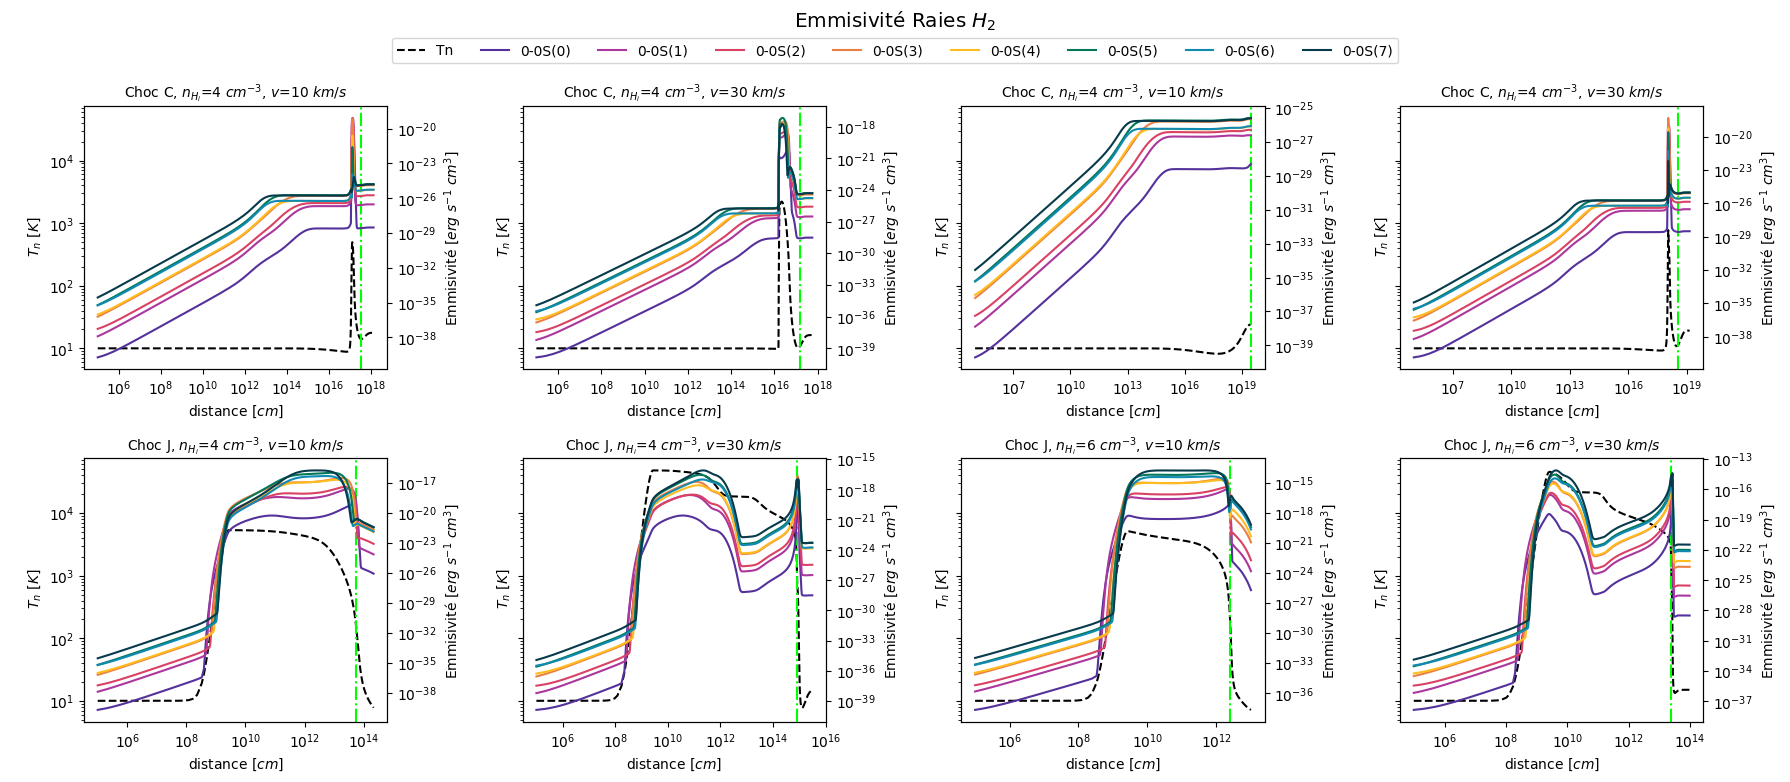

In [213]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(18,7.2), layout='constrained', sharey=True)
colores=["#54319b","#ab369d","#d94165","#ec7f42","#ffbc1f","#037758","#118ab2","#073b4c"]

for axsL, models in zip(axs, (Cmodels, Jmodels)):
    for axi, model in zip(axsL, models):
        data = models[model]['H2_line_loc']
        ceil=models[model]['ceil']
        Dmask=data["distance"]<ceil*4
        
        axi.plot(data[Dmask]["distance"], data[Dmask][emm[0]], label=emm[0] if model == 'Cn4b5v30' else None, c="black", ls="--")
        axi.axvline(ceil, ls='-.', c="#00FF00")
        ax=axi.twinx()
        for j in range(1,len(emm)):
            ax.plot(data[Dmask]["distance"], data[Dmask][emm[j]], label=emm[j] if model == 'Cn4b5v30' else None, c=colores[j-1])

        ax.set_title(name_to_desc(model), size='medium')
        ax.set_yscale("log")
        axi.set_yscale("log")
        axi.set_xscale("log")
        axi.set_xlabel("distance [$cm$]")
        axi.set_ylabel("\n $T_n$ [$K$]")
        ax.set_ylabel("Emmisivité [$erg$ $s^{-1}$ $cm^3$]")
fig.tight_layout()
fig.legend(loc='upper center', ncols=9, bbox_to_anchor=(0.5, 1.05))
fig.suptitle(f"Emmisivité Raies $H_2$", size="x-large", y=1.08)
fig.savefig('emmisivites.png', dpi=300, bbox_inches='tight')

## Comparaison aux observations

In [152]:
raies={1: 17.03484*u.um, 2: 12.2785*u.um, 3: 9.6649*u.um, 4: 8.0258*u.um, 5: 6.9091*u.um, 6: 6.1089*u.um, 7: 5.5115*u.um, 0:28.2188*u.um}
E_up = {1: 1015.0*u.K, 2:1682.0*u.K, 3:2503.4*u.K, 4:3474.6*u.K, 5:4586.7*u.K, 6:5829.8*u.K, 7:7196.6*u.K, 0: 509.9*u.K}
A_ij = {1: 4.76e-10*u.Hz, 2:2.76e-9*u.Hz, 3:9.84e-9*u.Hz, 4:2.64e-8*u.Hz, 5:5.88e-8*u.Hz, 6:1.14e-7*u.Hz, 7:2.00e-7*u.Hz, 0:2.94e-11*u.Hz}

### Methode Exit

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(20,10), layout='constrained')
for ax, model in zip(axs[0], Cmodels):
    data = Cmodels[model]['excit']
    ax.plot([E_up[r].value for r in range(8)], data['log(N/g)'][:8], marker='x', ls='--')

    ax.set_title(model)
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")

    ax.set_ylim(25,75)
    # ax.legend()

for ax, model in zip(axs[1], Jmodels):
    data = Jmodels[model]['excit']
    ax.plot([E_up[r].value for r in range(8)], data['log(N/g)'][:8], marker='x', ls='--')

    ax.set_title(model)
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
    
    ax.set_ylim(25,75)
    # ax.legend()

fig.suptitle(f"Diagramme d'Excitation - excit.out")

In [180]:
it_lim=3
xT1=np.array([E_up[r].value for r in range(it_lim)])
xT2=np.array([E_up[r].value for r in range(it_lim,8)])

def linea(x,m,b): return m*x+b

def ajuste(models):
    for model in models:
        models[model]['popt_T1']=dict()
        models[model]['popt_T2']=dict()

        data = models[model]['excit']

        popt, pcov = spo.curve_fit(linea, xT1, [data['log(N/g)'][r] for r in range(it_lim)])
        models[model]['popt_T1']=popt
        
        popt, pcov = spo.curve_fit(linea, xT2, [data['log(N/g)'][r] for r in range(it_lim,8)])
        models[model]['popt_T2']=popt

ajuste(Cmodels)
ajuste(Jmodels)

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(20,10), layout='constrained')
for ax, model in zip(axs[0], Cmodels):
    data = Cmodels[model]['excit']
    ax.plot([E_up[r].value for r in range(8)], data['log(N/g)'][:8], marker='x', ls='--')

    ax.plot(np.concatenate((xT1,xT2)), linea(np.concatenate((xT1,xT2)),Cmodels[model]['popt_T2'][0],Cmodels[model]['popt_T2'][1]), 
            '--', label=f"T={-1/Cmodels[model]['popt_T2'][0]:.2e} K", c='#0000FF')
    ax.plot(np.concatenate((xT1,xT2)), linea(np.concatenate((xT1,xT2)),Cmodels[model]['popt_T1'][0],Cmodels[model]['popt_T1'][1]), 
            '-.', label=f"T={-1/Cmodels[model]['popt_T1'][0]:.2e} K", c='#FF0000')    

    ax.set_title(model)
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
    ax.set_ylim(25,75)
    ax.legend()

for ax, model in zip(axs[1], Jmodels):
    data = Jmodels[model]['excit']
    ax.plot([E_up[r].value for r in range(8)], data['log(N/g)'][:8], marker='x', ls='--')

    ax.plot(np.concatenate((xT1,xT2)), linea(np.concatenate((xT1,xT2)),Jmodels[model]['popt_T2'][0],Jmodels[model]['popt_T2'][1]), 
            '--', label=f"T={-1/Jmodels[model]['popt_T2'][0]:.2e} K", c='#0000FF')
    ax.plot(np.concatenate((xT1,xT2)), linea(np.concatenate((xT1,xT2)),Jmodels[model]['popt_T1'][0],Jmodels[model]['popt_T1'][1]), 
            '-.', label=f"T={-1/Jmodels[model]['popt_T1'][0]:.2e} K", c='#FF0000')

    ax.set_title(model)
    ax.set_xlabel("$E_{up}/k_B$ [K]")
    ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
    ax.set_ylim(25,75)
    ax.legend()

fig.suptitle(f"Diagramme d'Excitation - excit - temp.out")

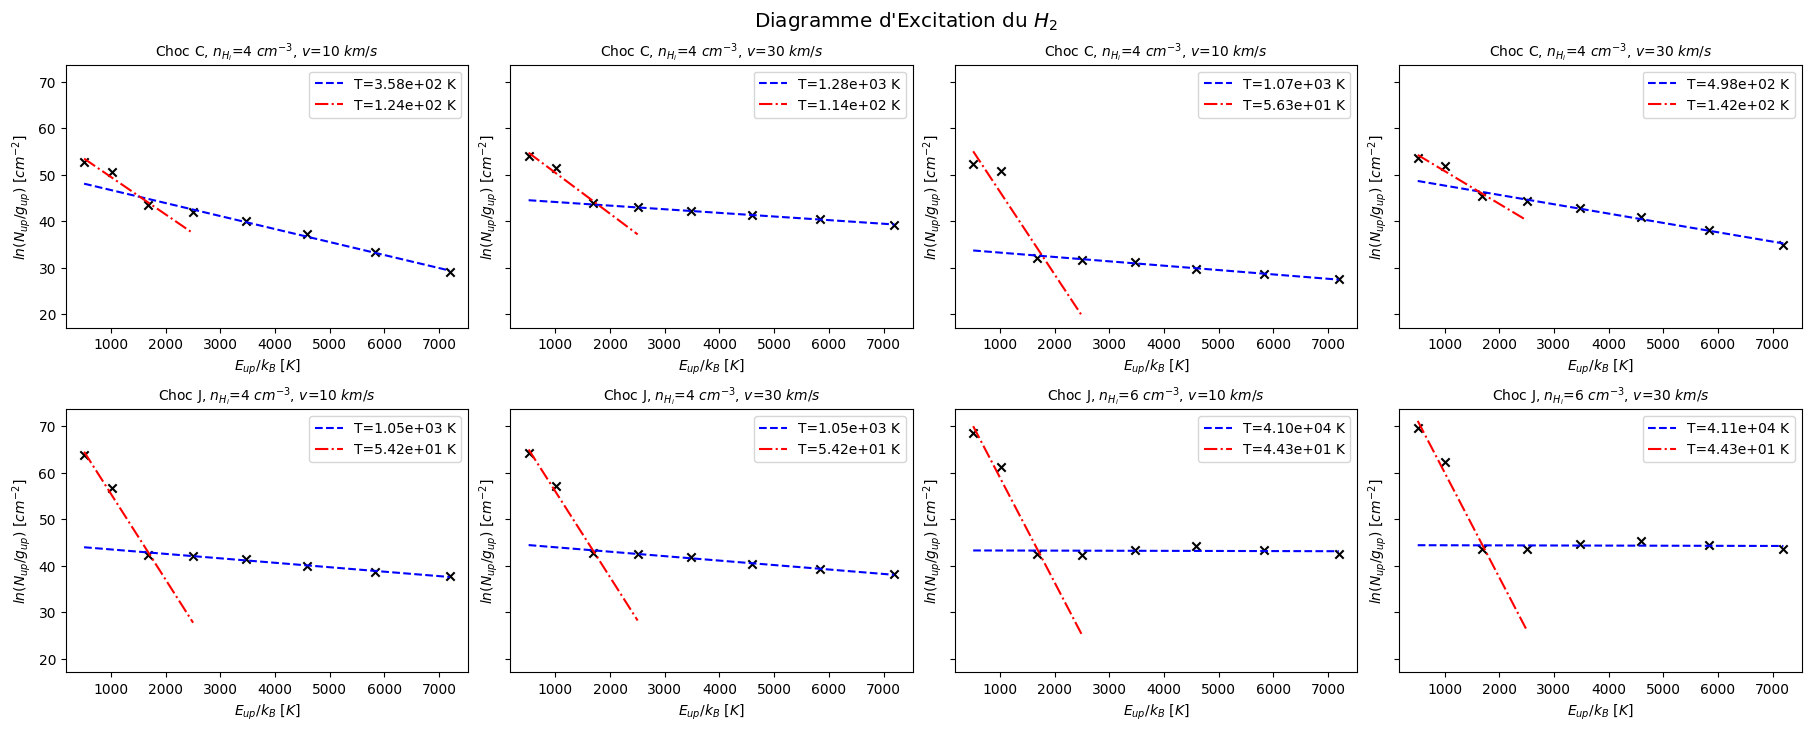

In [211]:
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(18,7.2), layout='constrained', sharey=True)

for axsL, models in zip(axs, (Cmodels, Jmodels)):
    for ax, model in zip(axsL, models):
        data = models[model]['excit']

        ax.scatter([E_up[r].value for r in range(8)], data['log(N/g)'][:8], marker='x', c='black')

        ax.plot(np.concatenate((xT1[-3:],xT2)), linea(np.concatenate((xT1[-3:],xT2)),models[model]['popt_T2'][0],models[model]['popt_T2'][1]), 
                '--', label=f"T={-1/models[model]['popt_T2'][0]:.2e} K", c='#0000FF')
        
        ax.plot(np.concatenate((xT1,xT2[:1])), linea(np.concatenate((xT1,xT2[:1])),models[model]['popt_T1'][0],models[model]['popt_T1'][1]), 
                '-.', label=f"T={-1/models[model]['popt_T1'][0]:.2e} K", c='#FF0000') 
    
        ax.set_xlabel("$E_{up}/k_B$ [$K$]")
        ax.set_ylabel("$ln(N_{up}/g_{up})$ [$cm^{-2}$]")
        ax.set_title(name_to_desc(model), size='medium')
        ax.legend(loc='upper right')

fig.suptitle(f"Diagramme d'Excitation du $H_2$", size="x-large")
fig.savefig('excit_models.png', dpi=300, bbox_inches='tight')